<a href="https://colab.research.google.com/github/AirNicco8/NLP_Unibo_Project_Work/blob/main/SetFit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [1]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 5.3 MB 56.5 MB/s 
     |████████████████████████████████| 1.3 MB 46.5 MB/s 
     |████████████████████████████████| 163 kB 72.3 MB/s 
     |████████████████████████████████| 7.6 MB 56.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d8d71de5edf0e63f439c77fceb831fd9989d4d9c5710ee208711acb449770695
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [2]:

  # if(classifier == "LogisticRegression"):
  #   sgd =  LogisticRegression()
  #   sgd.fit(X_train, y_train)
  #   y_pred_eval_sgd = sgd.predict(X_eval)
  # else:
  #   clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, class_weight='balanced'))
  #   clf.fit(X_train, y_train)
  #   y_pred_eval_sgd = clf.predict(X_eval)

  # if not multi:
  #   print('Acc. SetFit', accuracy_score(y_eval, y_pred_eval_sgd))
  #   print('F1 SetFit', f1_score(y_eval, y_pred_eval_sgd))

  # print('')
  # print("Report")
  # print(classification_report(y_eval, y_pred_eval_sgd, target_names=target_names))

  # cnf_matrix = confusion_matrix(y_eval, y_pred_eval_sgd)

  # class_names=[0,1] # name  of classes
  # fig, ax = plt.subplots()
  # tick_marks = np.arange(len(class_names))
  # plt.xticks(tick_marks, class_names)
  # plt.yticks(tick_marks, class_names)
  # # create heatmap
  # sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  # ax.xaxis.set_label_position("top")
  # plt.tight_layout()
  # plt.title('SetFit Confusion matrix', y=1.1)
  # plt.ylabel('Actual label')
  # plt.xlabel('Predicted label')



In [3]:
def print_metrics(x_train, x_eval, y_train, y_eval, classifier, multi, target_names, fit):
  if(classifier == "LogisticRegression"):
    sgd =  LogisticRegression()
    sgd.fit(x_train, y_train)
    y_pred_eval_sgd = sgd.predict(x_eval)
  else:
    clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, class_weight='balanced'))
    clf.fit(x_train, y_train)
    y_pred_eval_sgd = clf.predict(x_eval)

  if not multi:
    print('Acc. No Fit', accuracy_score(y_eval, y_pred_eval_sgd))
    print('F1 No Fit', f1_score(y_eval, y_pred_eval_sgd))

  print('')
  print("Report")
  print(classification_report(y_eval, y_pred_eval_sgd, target_names=target_names))
  
  cnf_matrix = confusion_matrix(y_eval, y_pred_eval_sgd)

  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('{} Confusion matrix'.format(fit), y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


In [4]:
def plot(X_train_noFT, X_train, X_eval_noFT, X_eval, y_train, y_eval):
    plt.figure(figsize=(20,10))

  #Plot X_train_noFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train_noFT))
    plt.subplot(221)
    plt.title('X_train No Fit')

    for i, t in enumerate(set(np.array(y_train))):
        idx = np.array(y_train) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));

  #Plot X_eval noFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval_noFT))
    plt.subplot(223)
    plt.title('X_eval No Fit')

    for i, t in enumerate(set(np.array(y_eval))):
        idx = np.array(y_eval) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));


  #Plot X_train SetFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train))

    plt.subplot(222)
    plt.title('X_train SetFit')

    for i, t in enumerate(set(np.array(y_train))):
        idx = np.array(y_train) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));

  #Plot X_eval SetFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval))
    plt.subplot(224)
    plt.title('X_eval SetFit')

    for i, t in enumerate(set(np.array(y_eval))):
        idx = np.array(y_eval) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));

# Methods

In [5]:
def eval(x_train, x_eval, y_train, y_eval, lan, multi=False):
  if lan == 'en':
    target_names = ['bad review', 'good review']
  elif lan == 'it':
    target_names = ['other', 'political']
  elif lan == 'ger':
    target_names = ['Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport',
       'Web', 'Wirtschaft', 'Wissenschaft']

  print("-------------- No Fit --------------")
  X_train_noFT = orig_model.encode(x_train)
  X_eval_noFT = orig_model.encode(x_eval)

  print_metrics(X_train_noFT, X_eval_noFT, y_train, y_eval, classifier, multi, target_names, 'No Fit')

  print("-----------------------------------------")
  print('')
  print("-------------- With SetFit --------------")
  X_train = model.encode(x_train)
  X_eval = model.encode(x_eval)

  print_metrics(X_train, X_eval, y_train, y_eval, classifier, multi, target_names, 'With SetFit')

  print("-----------------------------------------")
  print('')

  #Plot 2-D 2x2 figures
  if plot2d_checkbox:   
    plot(X_train_noFT, X_train, X_eval_noFT, X_eval, y_train, y_eval)


In [6]:
def clean(df):
  df['text'] = df['text'].str.replace(r'\s*@\w+ ', '', regex=True).replace(r'\\+@\w+', '', regex=True).replace(r'\\+@\w+ ', '', regex=True) # remove mentions
  df['text'] = df['text'].replace(r'http\S+', '', regex=True).replace(r'http\S+ ', '', regex=True).replace(r'www\S+ ', '', regex=True) # remove links
  return df

In [7]:
def sentence_pairs_generation(sentences, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if a pair is positive or negative

  #numClassesList = np.unique(labels)
  #idx = [np.where(labels == i)[0] for i in numClassesList] # indexes of label i for i in 0..numClasses

  for idxA in range(len(sentences)):      
    currentSentence = sentences[idxA]
    label = labels[idxA]

    #idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
    #posSentence = sentences[idxB]

    idxB = np.where(labels == label)[0] # indexes of sentences with different label than current
    posSentence = sentences[np.random.choice(idxB)]
		  # prepare a positive pair and update the sentences and labels
		  # lists, respectively
    pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0)) 

    negIdx = np.where(labels != label)[0] # indexes of sentences with different label than current
    negSentence = sentences[np.random.choice(negIdx)] 
		  # prepare a negative pair of images and update our lists
    pairs.append(InputExample(texts=[currentSentence, negSentence], label=0.0))
  
	# return a 2-tuple of our image pairs and labels
  return (pairs) # 2*len(sentences)

# Init

In [9]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

# Multi Language student (it-en-de)

## Italian Text Classification

### CSV Download + basic cleaning

In [10]:
#SENTIPOLC
# Load Sentipolc training dataset into a pandas dataframe.
ita_train_df = clean(pd.read_csv('https://raw.githubusercontent.com/AirNicco8/NLP_Unibo_Project_Work/main/data/training_set_sentipolc16.csv', delimiter=',', header=0))

In [11]:
# Load the test dataset into a pandas dataframe.
ita_eval_df = clean(pd.read_csv('https://raw.githubusercontent.com/AirNicco8/NLP_Unibo_Project_Work/main/data/test_set_sentipolc16_gold2000.csv', delimiter=',', header=0, on_bad_lines='skip'))

In [12]:
# we just keep the text column and the topic label (1 for politics and 0 for other)
ita_train_df.drop(columns=ita_train_df.columns.values[:-2], inplace = True)
ita_eval_df.drop(columns=ita_eval_df.columns.values[:-2], inplace = True)

In [13]:
# in the eval dataframe the politics label is 2, so we map to 1
ita_eval_df.top = ita_eval_df.top.map({2:1, 0:0})

In [14]:
values, count = np.unique(ita_eval_df.top.values, return_counts=True)
values, count # classes are heavily unbalanced in test set

(array([0, 1]), array([ 482, 1460]))

In [15]:
balanced_ita_eval_df = ita_eval_df[ita_eval_df['top']==0]
balanced_ita_eval_df = pd.concat([balanced_ita_eval_df, ita_train_df[ita_train_df['top']==1].sample(len(balanced_ita_eval_df))])
balanced_ita_eval_df # create a balanced dataset for evaluation

,top,text
1460,0,LINK: | #avventure #annoiata #carsex #lombard...
1461,0,"bene anche se sto morendo di sonno, ieri appen..."
1462,0,Strada ampia rallegra gli indigeni! Ora la mia...
1463,0,#20ThingsIWantIn2015 7)vedere tutte le serie t...
1464,0,Robo-Advisor : il Cavallo di Troia della finan...
...,...,...
1165,1,Mario Monti: il programma di Governo
2438,1,In #conferenzastampa Governo Monti inviti al c...
583,1,rassegna stampa anti-NWO: Chi è Mario Monti? U...
1467,1,la #cgil domani riunisce a #roma 15.000 delega...


In [16]:
balance = True #@param {type: 'boolean'}
# if set to true balances the classes in dataset removing data

text_col = ita_eval_df.columns.values[1] 
category_col = ita_eval_df.columns.values[0]

x_eval = balanced_ita_eval_df[text_col].values.tolist() if balance else ita_eval_df[text_col].values.tolist()
y_eval = balanced_ita_eval_df[category_col].values.tolist() if balance else ita_eval_df[category_col].values.tolist()

### Parallel Dataset & Params

In [17]:
st_model = "airnicco8/xlm-roberta-en-it-de" #@param ["airnicco8/xlm-roberta-en-it-de"]
num_training = 32 #@param ["8", "16", "32", "64", "128", "256", "512"] {type:"raw"}
num_itr = 5 #@param ["1", "2", "3", "4", "5", "10"] {type:"raw"}
classifier = "SGDClassifier" #@param ["LogisticRegression", "SGDClassifier"]
plot2d_checkbox = True #@param {type: 'boolean'}

set_seed(0)
# Equal samples per class training
train_df_sample = pd.concat([ita_train_df[ita_train_df[category_col]==0].sample(num_training), ita_train_df[ita_train_df[category_col]==1].sample(num_training)])
x_train = train_df_sample[text_col].values.tolist()
y_train = train_df_sample[category_col].values.tolist()

train_examples = [] 
for x in range(num_itr):
  train_examples = sentence_pairs_generation(np.array(x_train), np.array(y_train), train_examples)


In [18]:
len(train_examples)

640

### Ita Training

In [19]:
orig_model = SentenceTransformer(st_model)
model = SentenceTransformer(st_model)

# S-BERT adaptation 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=10, show_progress_bar=True)

Downloading:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/698 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/124 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

### Ita Evaluation

-------------- No Fit --------------
Acc. No Fit 0.8309128630705395
F1 No Fit 0.8260405549626468

Report
              precision    recall  f1-score   support

       other       0.81      0.86      0.84       482
   political       0.85      0.80      0.83       482

    accuracy                           0.83       964
   macro avg       0.83      0.83      0.83       964
weighted avg       0.83      0.83      0.83       964

-----------------------------------------

-------------- With SetFit --------------
Acc. No Fit 0.9678423236514523
F1 No Fit 0.9680082559339525

Report
              precision    recall  f1-score   support

       other       0.97      0.96      0.97       482
   political       0.96      0.97      0.97       482

    accuracy                           0.97       964
   macro avg       0.97      0.97      0.97       964
weighted avg       0.97      0.97      0.97       964

-----------------------------------------



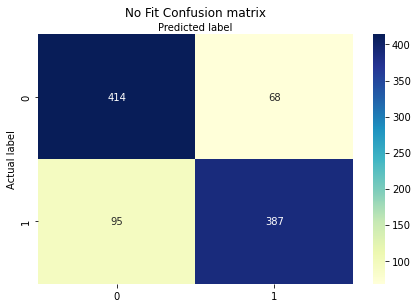

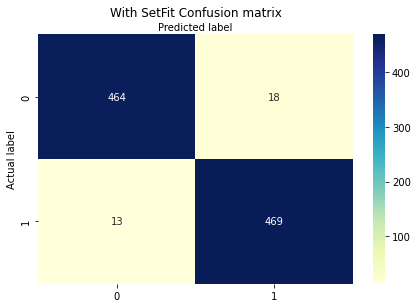

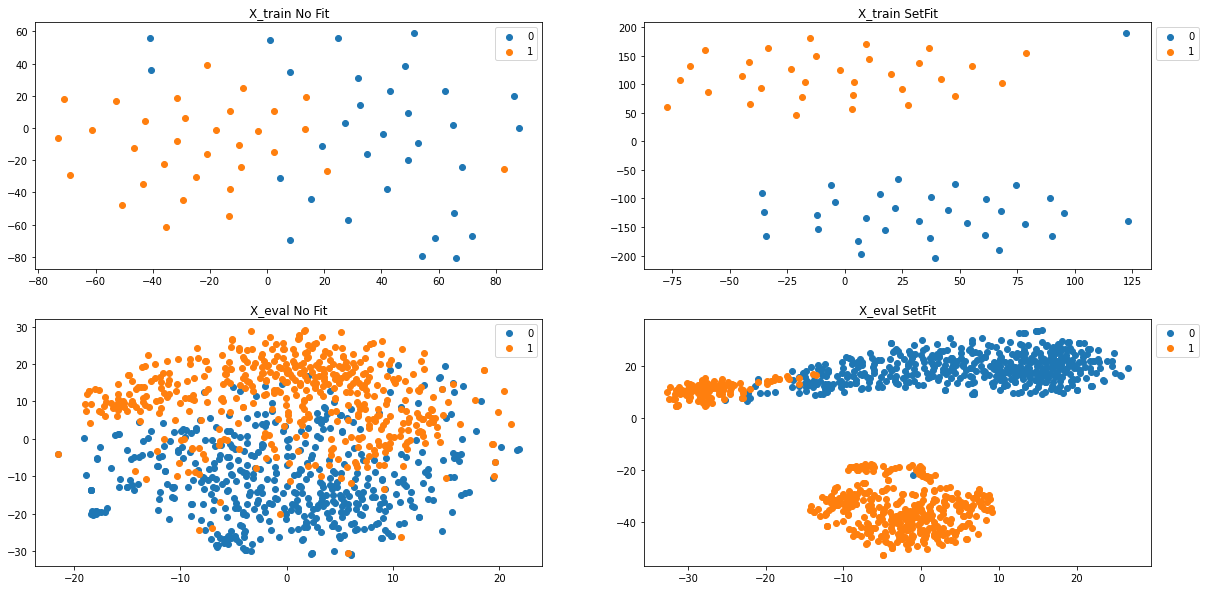

In [20]:
eval(x_train, x_eval, y_train, y_eval, 'it')

## English Text Classification

### Eng Data Preparation

In [21]:
#SST-2
# Load SST-2 dataset into a pandas dataframe.
eng_train_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

# Load the test dataset into a pandas dataframe.
eng_eval_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

In [22]:
text_col=eng_train_df.columns.values[0] 
category_col=eng_train_df.columns.values[1]

x_eval = eng_eval_df[text_col].values.tolist()
y_eval = eng_eval_df[category_col].values.tolist()

### Parallel Dataset & Params

In [23]:
st_model = "airnicco8/xlm-roberta-en-it-de" #@param ["airnicco8/xlm-roberta-en-it-de"]
num_training = 32 #@param ["8", "16", "32", "64", "128", "256", "512"] {type:"raw"}
num_itr = 5 #@param ["1", "2", "3", "4", "5", "10"] {type:"raw"}
classifier = "SGDClassifier" #@param ["LogisticRegression", "SGDClassifier"]
plot2d_checkbox = True #@param {type: 'boolean'}

set_seed(0)
# Equal samples per class training
train_df_sample = pd.concat([eng_train_df[eng_train_df[1]==0].sample(num_training), eng_train_df[eng_train_df[1]==1].sample(num_training)])
x_train = train_df_sample[text_col].values.tolist()
y_train = train_df_sample[category_col].values.tolist()

train_examples = [] 
for x in range(num_itr):
  train_examples = sentence_pairs_generation(np.array(x_train), np.array(y_train), train_examples)


In [24]:
len(train_examples)

640

### Eng Training

In [25]:
orig_model = SentenceTransformer(st_model)
model = SentenceTransformer(st_model)

# S-BERT adaptation 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=10, show_progress_bar=True)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

### Eng Evaluation

-------------- No Fit --------------
Acc. No Fit 0.7484898407468424
F1 No Fit 0.7447045707915274

Report
              precision    recall  f1-score   support

  bad review       0.74      0.76      0.75       912
 good review       0.75      0.73      0.74       909

    accuracy                           0.75      1821
   macro avg       0.75      0.75      0.75      1821
weighted avg       0.75      0.75      0.75      1821

-----------------------------------------

-------------- With SetFit --------------
Acc. No Fit 0.8412959912136189
F1 No Fit 0.8351397604107245

Report
              precision    recall  f1-score   support

  bad review       0.82      0.88      0.85       912
 good review       0.87      0.81      0.84       909

    accuracy                           0.84      1821
   macro avg       0.84      0.84      0.84      1821
weighted avg       0.84      0.84      0.84      1821

-----------------------------------------



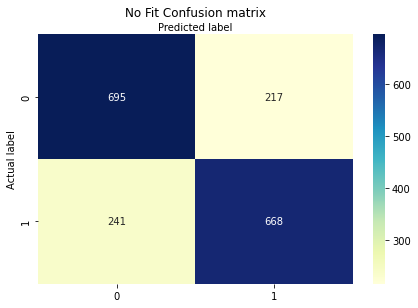

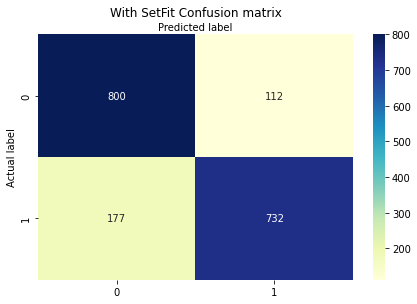

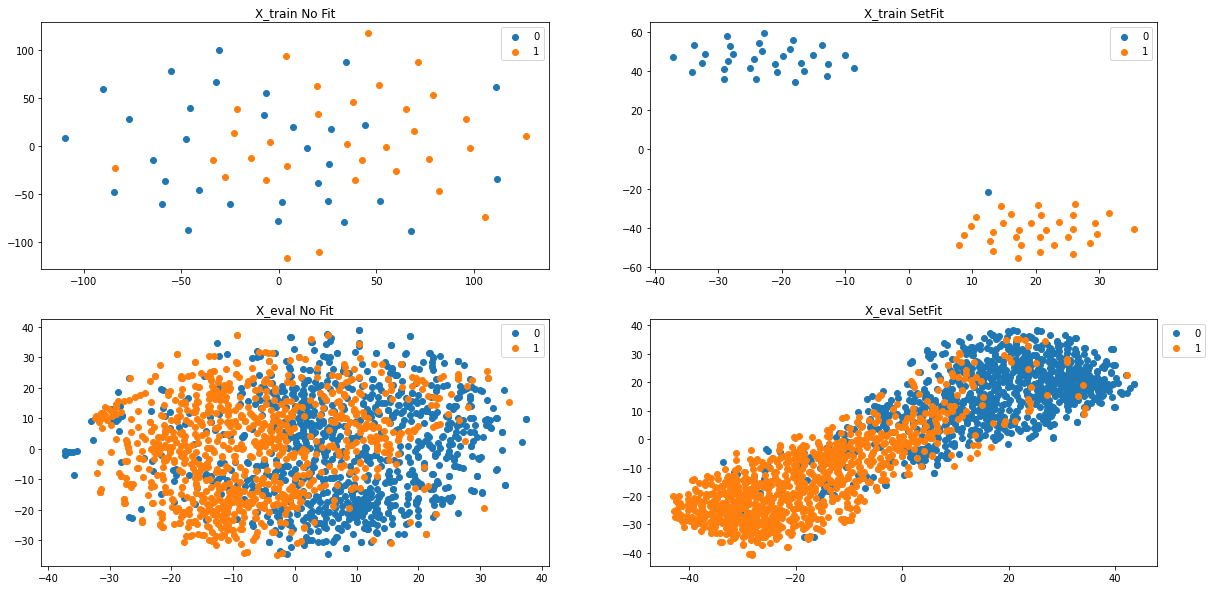

In [26]:
eval(x_train, x_eval, y_train, y_eval, 'en')

## German Text Multi-Classification

### Ger Data Preparation

In [27]:
%env DIR=../../data

!mkdir -p $DIR
!wget -nc https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O $DIR/train.csv
!wget -nc https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O $DIR/test.csv
!ls -lAh $DIR | cut -d " " -f 5-

env: DIR=../../data
2022-10-20 14:08:08 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv [24405789/24405789] -> "../../data/train.csv" [1]
2022-10-20 14:08:10 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv [2755020/2755020] -> "../../data/test.csv" [1]

2.7M Oct 20 14:08 test.csv
 24M Oct 20 14:08 train.csv


In [28]:
data_path = Path('../../data/')

train_file = data_path / "train.csv"
test_file = data_path / "test.csv"

In [29]:
def load_10kGNAD(filepath: Path, columns: list=["labels", "text"]) -> pd.DataFrame:
    """Load 10kGNAD-specific data format from CVS file."""
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=columns)
    return f

In [30]:
# load the dataset splits
ger_train_df = load_10kGNAD(train_file)
ger_eval_df = load_10kGNAD(test_file)

In [31]:
values, count = np.unique(y_eval, return_counts=True)
dict(zip(values, count)) # classes are unbalanced in test set

{0: 912, 1: 909}

#### Map multi class labels to int

In [32]:
ger_train_df['labels'] = ger_train_df['labels'].astype('category')

In [33]:
cats = ger_train_df['labels'].cat.categories.values
ncats = len(cats)

In [34]:
multiclass_dict = dict(zip(cats, range(ncats)))
multiclass_dict

{'Etat': 0,
 'Inland': 1,
 'International': 2,
 'Kultur': 3,
 'Panorama': 4,
 'Sport': 5,
 'Web': 6,
 'Wirtschaft': 7,
 'Wissenschaft': 8}

In [35]:
ger_train_df['labels'] = ger_train_df['labels'].map(multiclass_dict)
ger_eval_df['labels'] = ger_eval_df['labels'].map(multiclass_dict)

In [36]:
text_col=ger_train_df.columns.values[1] 
category_col=ger_train_df.columns.values[0]
# text and label column indentifiers

x_eval = ger_eval_df[text_col].values.tolist()
y_eval = ger_eval_df[category_col].values.tolist()

### Parallel Dataset & Params

In [37]:
st_model = "airnicco8/xlm-roberta-en-it-de" #@param ["airnicco8/xlm-roberta-en-it-de"]
num_training = 4 #@param ["4", "8", "16", "32", "64", "128", "256", "512"] {type:"raw"}
num_itr = 3 #@param ["1", "2", "3", "4", "5", "10"] {type:"raw"}
classifier = "SGDClassifier" #@param ["LogisticRegression", "SGDClassifier"]
plot2d_checkbox = True #@param {type: 'boolean'}

set_seed(0)
# Equal samples per class training
train_df_sample = pd.concat([ger_train_df[ger_train_df[category_col]==0].sample(1), ger_train_df[ger_train_df[category_col]==6].sample(1)])
# do forma al dataframe per inizializzarlo
for i in range(ncats):
  other_classes = list(set(range(ncats))-set([i])) # fermo la classe di riferimento
  for j in other_classes:
    tmp = pd.concat([ger_train_df[ger_train_df[category_col]==i].sample(num_training), ger_train_df[ger_train_df[category_col]==j].sample(num_training)])

    # aggiungo num_training sample negativi per ogni altra classe
    train_df_sample = train_df_sample.append(tmp)
    # add num_training*2 sample per loop
  # add num_training*2*8 sample per loop
# total samples -> num_training*2*8*9

train_df_sample=train_df_sample.drop(train_df_sample.index[0:2].values)
# rimuovo le prime 2 righe che hanno inizializzato

x_train = train_df_sample[text_col].values.tolist()
y_train = train_df_sample[category_col].values.tolist()

train_examples = [] 
for x in range(num_itr):
  train_examples = sentence_pairs_generation(np.array(x_train), np.array(y_train), train_examples)


In [38]:
assert len(train_examples) == num_itr*2*(num_training*2*8*9) #<- x_train

### Ger Training

In [39]:
orig_model = SentenceTransformer(st_model)
model = SentenceTransformer(st_model)

# S-BERT adaptation 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=10, show_progress_bar=True)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/216 [00:00<?, ?it/s]

### Ger Evaluation

-------------- No Fit --------------

Report
               precision    recall  f1-score   support

         Etat       0.72      0.66      0.69        67
       Inland       0.61      0.73      0.66       102
International       0.73      0.75      0.74       151
       Kultur       0.69      0.85      0.76        54
     Panorama       0.77      0.64      0.70       168
        Sport       0.93      0.94      0.93       120
          Web       0.84      0.83      0.83       168
   Wirtschaft       0.76      0.65      0.70       141
 Wissenschaft       0.61      0.81      0.70        57

     accuracy                           0.75      1028
    macro avg       0.74      0.76      0.75      1028
 weighted avg       0.76      0.75      0.75      1028

-----------------------------------------

-------------- With SetFit --------------

Report
               precision    recall  f1-score   support

         Etat       0.78      0.67      0.72        67
       Inland       0.64      0.7

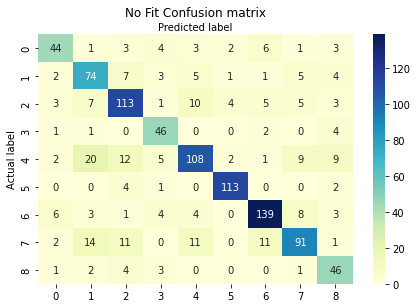

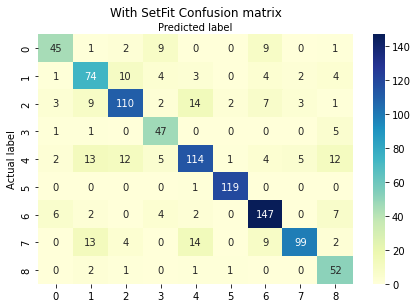

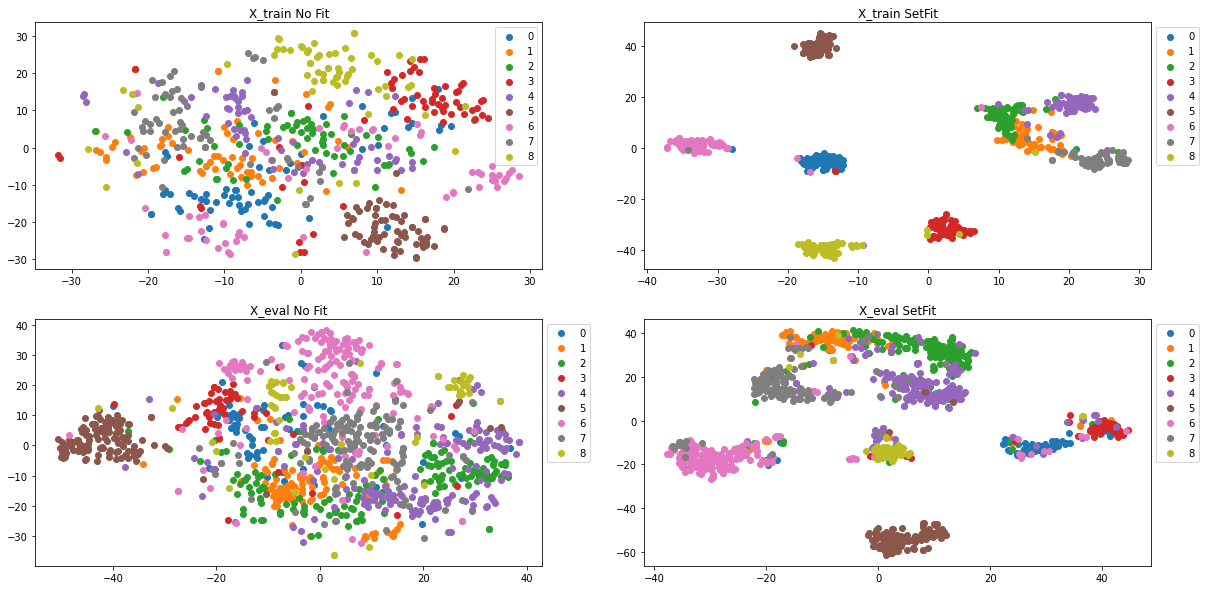

In [40]:
eval(x_train, x_eval, y_train, y_eval, 'ger', True) 